In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt
import tensorflow as tf
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from numpy import array , hstack
from tensorflow import keras

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_data.csv to test_data (1).csv
Saving train_data.csv to train_data (1).csv
Saving validation_data.csv to validation_data (1).csv


In [ ]:
import io
df1 = pd.read_csv(io.BytesIO(uploaded['train_data.csv']))

import io
df_test = pd.read_csv(io.BytesIO(uploaded['test_data.csv']))

import io
df_validate = pd.read_csv(io.BytesIO(uploaded['validation_data.csv']))

In [ ]:
# Print the header of the DataFrame
df1.head()

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5


In [ ]:
# Print info of DataFrame
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19921 entries, 0 to 19920
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CategoryCode  19921 non-null  object
 1   ItemCode      19921 non-null  int64 
 2   DateID        19921 non-null  object
 3   DailySales    19921 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 622.7+ KB


In [ ]:
# Print description of DataFrame
df1.DailySales.describe()

count    19921.000000
mean         7.351890
std         14.605342
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max        434.000000
Name: DailySales, dtype: float64

In [ ]:
len(df1['ItemCode'].unique())

194

In [ ]:
df1['ItemCode'].value_counts()

20824      136
132028     136
245581     136
17296      136
119554     136
          ... 
1090114     63
1068883     62
1090303     62
1090294     59
1015621     58
Name: ItemCode, Length: 194, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


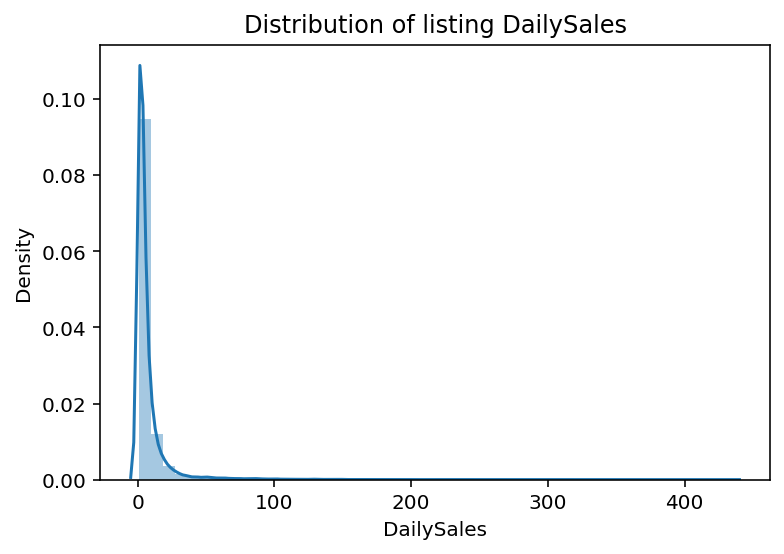

In [ ]:
# Visualize the distribution of the rating column
sns.distplot(df1['DailySales'],bins=50)
plt.title('Distribution of listing DailySales')
plt.show()

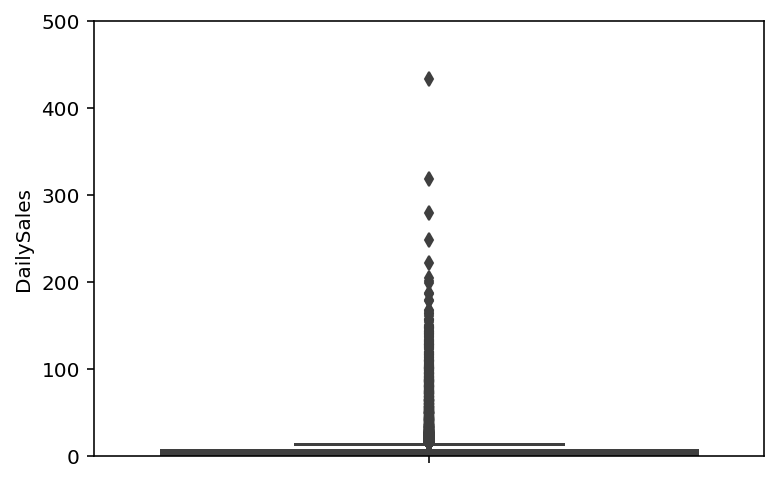

In [ ]:
# Visualize Boxplot
sns.boxplot( y = 'DailySales', data = df1)
plt.ylim(0,500)
plt.ylabel('DailySales')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


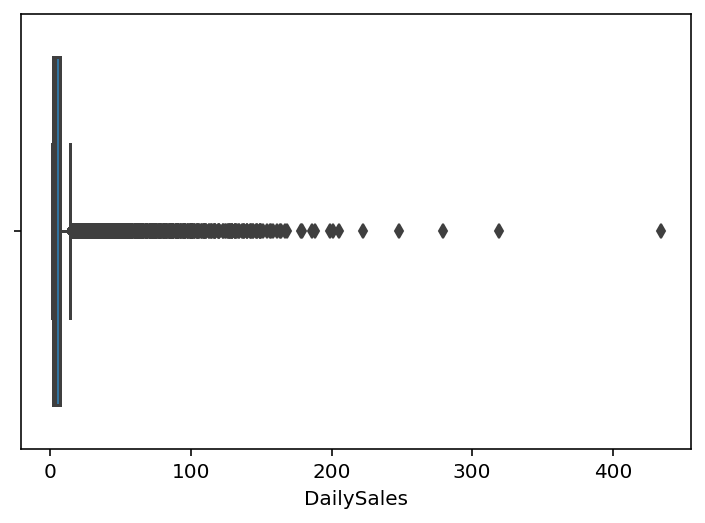

In [ ]:
# Box Plot
sns.boxplot(df1['DailySales'])

In [ ]:
# Position of the Outlier
print(np.where(df1['DailySales']>180))

(array([  195,  2437,  3690,  4692,  5251,  6336,  7029,  8557, 10726,
       11105]),)


In [ ]:
df2 = df1.loc[df1["DailySales"] <180 ]

In [ ]:
# Position of the Outlier
print(np.where(df2['DailySales']>180))

(array([], dtype=int64),)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


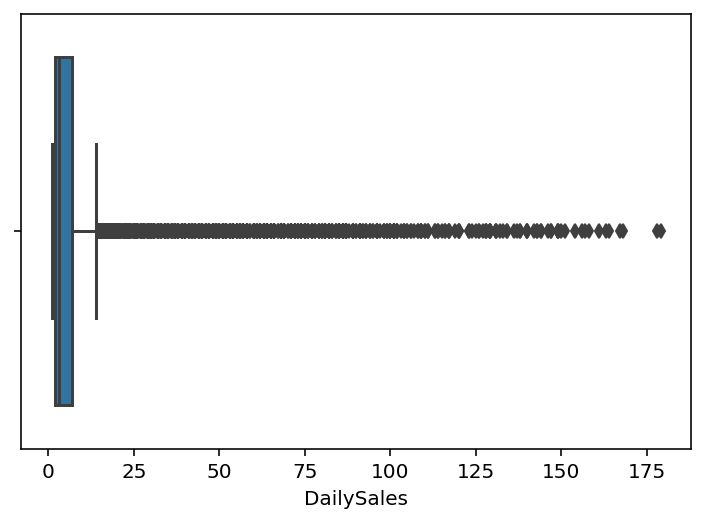

In [ ]:
# Box Plot
sns.boxplot(df2['DailySales'])

In [ ]:
# Print info of DataFrame
df1.info()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19921 entries, 0 to 19920
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CategoryCode  19921 non-null  object
 1   ItemCode      19921 non-null  int64 
 2   DateID        19921 non-null  object
 3   DailySales    19921 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 622.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19911 entries, 0 to 19920
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CategoryCode  19911 non-null  object
 1   ItemCode      19911 non-null  int64 
 2   DateID        19911 non-null  object
 3   DailySales    19911 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 777.8+ KB


In [ ]:
# Convert DateID columns to datetime
df2['DateID'] = pd.to_datetime(df2['DateID'], format = '%m/%d/%Y')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Print the header of the DataFrame
df2.head()

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,2021-11-06,7
1,category_4,836584,2021-11-18,16
2,category_1,370195,2022-01-24,6
3,category_2,172582,2021-10-30,5
4,category_2,1006009,2021-10-30,5


In [ ]:
start_date = '2021-10-01'
end_date = '2022-02-13'
mask = (df2['DateID'] > start_date) & (df2['DateID'] <= end_date)
  
df3 = df2.loc[mask]
display(df3)

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,2021-11-06,7
1,category_4,836584,2021-11-18,16
2,category_1,370195,2022-01-24,6
3,category_2,172582,2021-10-30,5
4,category_2,1006009,2021-10-30,5
...,...,...,...,...
19912,category_2,75886,2021-10-04,1
19915,category_1,36898,2021-10-12,1
19916,category_2,225259,2021-10-04,4
19917,category_2,111436,2021-10-12,1


In [ ]:
# Print info of DataFrame
df2.info()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19911 entries, 0 to 19920
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CategoryCode  19911 non-null  object        
 1   ItemCode      19911 non-null  int64         
 2   DateID        19911 non-null  datetime64[ns]
 3   DailySales    19911 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 777.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19768 entries, 0 to 19920
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CategoryCode  19768 non-null  object        
 1   ItemCode      19768 non-null  int64         
 2   DateID        19768 non-null  datetime64[ns]
 3   DailySales    19768 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 772.2+ KB


In [ ]:
temp=df3['DateID'].copy()

In [ ]:
df3.reset_index(inplace=True)

# Create new columns
df3['day'] = df3['DateID'].dt.day
df3['month'] = df3['DateID'].dt.month
df3['year'] = df3['DateID'].dt.year




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [146]:
import calendar
import numpy as np
# importing "array" for array creations
import array as arr
 
calendar.setfirstweekday(6)

def get_week_of_month(year, month, day):
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0] + 1
    return(week_of_month)

for i in range(0,19767):
  x = get_week_of_month(df3['year'].iloc[i],df3['month'].iloc[i],df3['day'].iloc[i])
  df3['Week'].iloc[i] = ('w'+ str(x))





/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [150]:
del df3["year"]


KeyError: ignored

In [151]:
del df3["month"]

In [152]:
del df3["day"]

In [149]:
display(df3)

,index,CategoryCode,ItemCode,DateID,DailySales,day,month,Week
0,0,category_2,117610,2021-11-06,7,6,11,w1
1,1,category_4,836584,2021-11-18,16,18,11,w3
2,2,category_1,370195,2022-01-24,6,24,1,w5
3,3,category_2,172582,2021-10-30,5,30,10,w5
4,4,category_2,1006009,2021-10-30,5,30,10,w5
...,...,...,...,...,...,...,...,...
19763,19912,category_2,75886,2021-10-04,1,4,10,w2
19764,19915,category_1,36898,2021-10-12,1,12,10,w3
19765,19916,category_2,225259,2021-10-04,4,4,10,w2
19766,19917,category_2,111436,2021-10-12,1,12,10,w3


In [ ]:
display(df3['DateID'])

0       2021-11-06
1       2021-11-18
2       2022-01-24
3       2021-10-30
4       2021-10-30
           ...    
19763   2021-10-04
19764   2021-10-12
19765   2021-10-04
19766   2021-10-12
19767   2021-10-04
Name: DateID, Length: 19768, dtype: datetime64[ns]

In [ ]:
df3['CategoryCode'].value_counts()

category_2    9137
category_1    6789
category_3    2339
category_4    1503
Name: CategoryCode, dtype: int64

In [ ]:
df3['ItemCode'].value_counts()

132028     135
245581     135
119554     135
20824      135
59749      135
          ... 
1090114     63
1068883     62
1090303     61
1090294     59
1015621     58
Name: ItemCode, Length: 194, dtype: int64

In [ ]:
uni_data = df3['DailySales']
uni_data.index = df3['DateID']
uni_data.head()


DateID
2021-11-06     7
2021-11-18    16
2022-01-24     6
2021-10-30     5
2021-10-30     5
Name: DailySales, dtype: int64

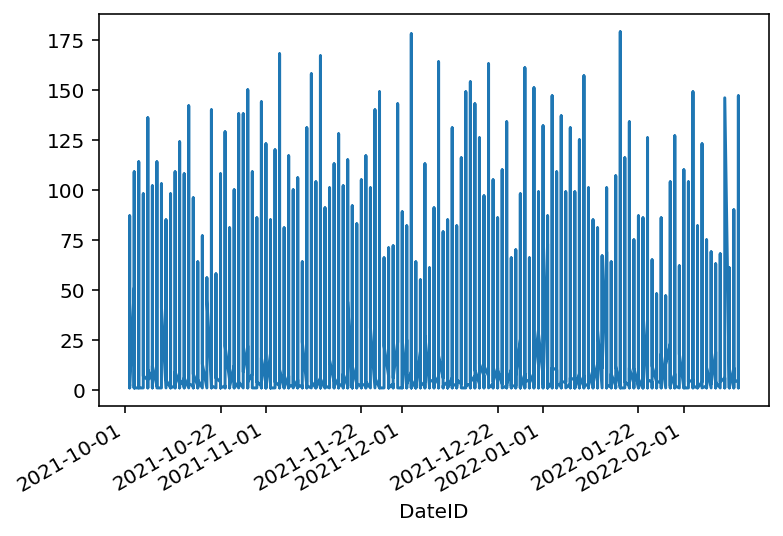

In [ ]:
uni_data.plot()

In [ ]:
# copy the data
df_min_max_scaled = df3.copy()
  
# apply normalization techniques (Min Max Normalization)
for column in df_min_max_scaled.columns:
    df_min_max_scaled['DailySales'] = (df_min_max_scaled['DailySales'] - df_min_max_scaled['DailySales'].min()) / (df_min_max_scaled['DailySales'].max() - df_min_max_scaled['DailySales'].min())    
  
# view normalized data
print(df_min_max_scaled)

       index CategoryCode  ItemCode     DateID  DailySales  day  month  year
0          0   category_2    117610 2021-11-06    0.033708    6     11  2021
1          1   category_4    836584 2021-11-18    0.084270   18     11  2021
2          2   category_1    370195 2022-01-24    0.028090   24      1  2022
3          3   category_2    172582 2021-10-30    0.022472   30     10  2021
4          4   category_2   1006009 2021-10-30    0.022472   30     10  2021
...      ...          ...       ...        ...         ...  ...    ...   ...
19763  19912   category_2     75886 2021-10-04    0.000000    4     10  2021
19764  19915   category_1     36898 2021-10-12    0.000000   12     10  2021
19765  19916   category_2    225259 2021-10-04    0.016854    4     10  2021
19766  19917   category_2    111436 2021-10-12    0.000000   12     10  2021
19767  19920   category_1    371104 2021-10-04    0.016854    4     10  2021

[19768 rows x 8 columns]


In [ ]:

# To find the correlation among
# the columns using pearson method
df_min_max_scaled.corr(method ='pearson')

,ItemCode,DailySales
ItemCode,1.000000,-0.137333
DailySales,-0.137333,1.000000


In [ ]:
# Print info of DataFrame
df_min_max_scaled.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19768 entries, 0 to 19767
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         19768 non-null  int64         
 1   CategoryCode  19768 non-null  object        
 2   ItemCode      19768 non-null  int64         
 3   DateID        19768 non-null  datetime64[ns]
 4   DailySales    19768 non-null  float64       
 5   day           19768 non-null  int64         
 6   month         19768 non-null  int64         
 7   year          19768 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CategoryCode    377 non-null    object 
 1   ItemCode        377 non-null    int64  
 2   Week            377 no

In [ ]:
DateID_1 = df_min_max_scaled['DateID']
CategoryCode_1 = df_min_max_scaled['CategoryCode']
ItemCode_1    = df_min_max_scaled['ItemCode']
DailySales_1    = df_min_max_scaled['DailySales']

DailySales_1  = DailySales_1.values

In [ ]:
from numpy import array
DateID_1 = array([DateID_1])
CategoryCode_1 = array([CategoryCode_1])
ItemCode_1 = array([ItemCode_1])
DailySales_1 = array([DailySales_1])


In [ ]:
# convert to [rows, columns] structure
DateID_1 = DateID_1.reshape((19768, 1))
CategoryCode_1 = CategoryCode_1.reshape((19768, 1))
ItemCode_1 = ItemCode_1.reshape((19768, 1))
DailySales_1 = DailySales_1.reshape((19768, 1))

print ("DateID_1.shape" , DateID_1.shape) 
print ("CategoryCode_1.shape" , CategoryCode_1.shape) 
print ("ItemCode_1.shape" , ItemCode_1.shape) 
print ("DailySales_1.shape" , DailySales_1.shape) 

DateID_1.shape (19768, 1)
CategoryCode_1.shape (19768, 1)
ItemCode_1.shape (19768, 1)
DailySales_1.shape (19768, 1)


In [ ]:
# horizontally stack columns
dataset_stacked = hstack((DateID_1, CategoryCode_1, ItemCode_1,  DailySales_1))

print ("dataset_stacked.shape" , dataset_stacked.shape) 

dataset_stacked.shape (19768, 4)


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	DateID_1, CategoryCode_1,ItemCode_1 ,DailySales_1 = list(), list(), list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_DateID_1, seq_CategoryCode_1, seq_ItemCode_1, seq_DailySales_1 = sequences[i:end_ix, :-1],sequences[i:end_ix, :-1],sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		DateID_1.append(seq_DateID_1), CategoryCode_1.append(seq_CategoryCode_1), ItemCode_1.append(seq_ItemCode_1)
		DailySales_1.append(seq_DailySales_1)
	return array(DateID_1), array(CategoryCode_1), array(ItemCode_1), array(DailySales_1)


In [ ]:
# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 60 , 30 

# covert into input/output
DateID_1,CategoryCode_1,ItemCode_1, DailySales_1 = split_sequences(dataset_stacked, n_steps_in, n_steps_out)

print ("DateID_1.shape" , DateID_1.shape) 
print ("CategoryCode_1.shape" , CategoryCode_1.shape) 
print ("ItemCode_1.shape" , ItemCode_1.shape) 
print ("DailySales_1.shape" , DailySales_1.shape) 

DateID_1.shape (19680, 60, 3)
CategoryCode_1.shape (19680, 60, 3)
ItemCode_1.shape (19680, 60, 3)
DailySales_1.shape (19680, 30)


In [ ]:
df_test.head()

,CategoryCode,ItemCode,Week,PredictedSales
0,category_1,43738,w4,NaN
1,category_2,1006090,w1,NaN
2,category_2,1076929,w4,NaN
3,category_1,1081321,w3,NaN
4,category_2,216151,w4,NaN


In [ ]:
print(df_test.iloc[376])

CategoryCode      category_2
ItemCode             1006090
Week                      w2
PredictedSales           NaN
Name: 376, dtype: object


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CategoryCode    377 non-null    object 
 1   ItemCode        377 non-null    int64  
 2   Week            377 non-null    object 
 3   PredictedSales  0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.9+ KB


In [ ]:
test_Week_1 = df_test['Week']
test_CategoryCode_1 = df_test['CategoryCode']
test_ItemCode_1    = df_test['ItemCode']
test_PredictedSales_1    = df_test['PredictedSales']

test_PredictedSales_1  = test_PredictedSales_1.values

In [ ]:
train_DateID , train_CategoryCode, train_ItemCode, train_DailySales = DateID_1[:19680, :] , CategoryCode_1[:19680, :], ItemCode_1[:19680, :], DailySales_1[:19680, :]

n_features = train_DateID.shape[2]

In [ ]:
#optimizer learning rate
opt = keras.optimizers.Adam(learning_rate=0.01)

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=['mse'])


In [ ]:
# Fit network
history = model.fit(train_X , train_y , epochs=60 , steps_per_epoch=25 , verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False)

NameError: ignored